In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
#sns.set_palette("Set1")

import warnings
warnings.filterwarnings("ignore")

In [8]:
iris = sns.load_dataset("iris")

In [9]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [10]:
iris.shape

(150, 5)

In [11]:
iris.species.value_counts()

versicolor    50
setosa        50
virginica     50
Name: species, dtype: int64

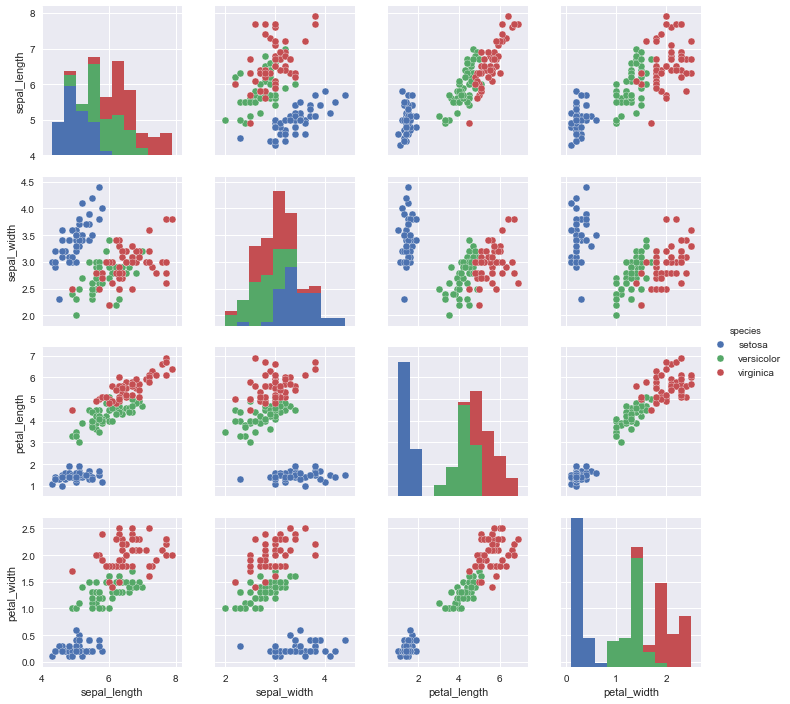

In [13]:
sns.pairplot(iris, hue="species");

In [14]:
iris_dummies = pd.get_dummies(iris, columns =['species'])

In [15]:
iris_dummies.sample(5)

,sepal_length,sepal_width,petal_length,petal_width,species_setosa,species_versicolor,species_virginica
50,7.0,3.2,4.7,1.4,0,1,0
47,4.6,3.2,1.4,0.2,1,0,0
57,4.9,2.4,3.3,1.0,0,1,0
140,6.7,3.1,5.6,2.4,0,0,1
122,7.7,2.8,6.7,2.0,0,0,1


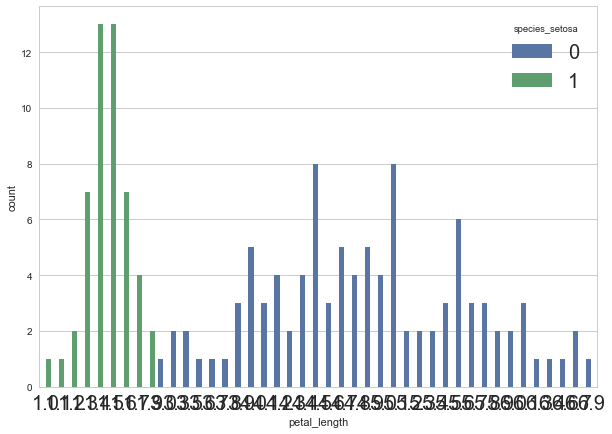

In [46]:
# sns.count brings some problems: the x label is not linear
plt.figure(figsize=(10,7))
sns.countplot(x='petal_length',hue='species_setosa',data=iris_dummies)

In [85]:
def plot_histogram(my_species,feature,n_bins=20):
    """Plot a histogram of the given feature according to a given species."""
    grouped_my_species = iris_dummies.groupby('species_'+my_species)
    hist_my_species= [group[feature] for _,group in grouped_my_species]
    sns.set_style("whitegrid")
    plt.figure(figsize=(10,7))
    plt.hist(hist_my_species, histtype='bar',normed=5,bins=n_bins,label=[my_species,'not '+my_species]);
    plt.yticks([])
    plt.legend()
    plt.xlabel(feature)
    sns.despine()

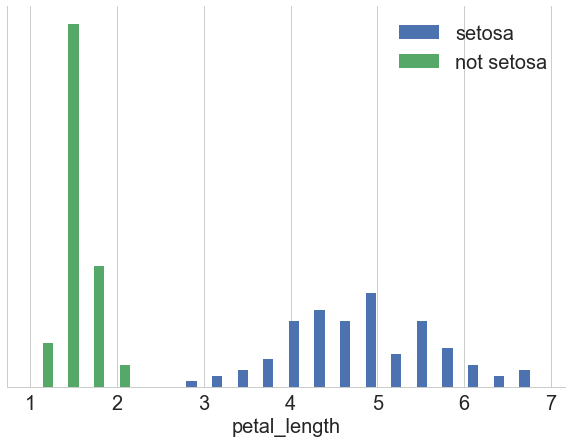

In [88]:
plt.rc('legend', fontsize=20) 
plt.rc('font', size=22)  
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('axes', labelsize=20) 
plot_histogram('setosa','petal_length')
        # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels


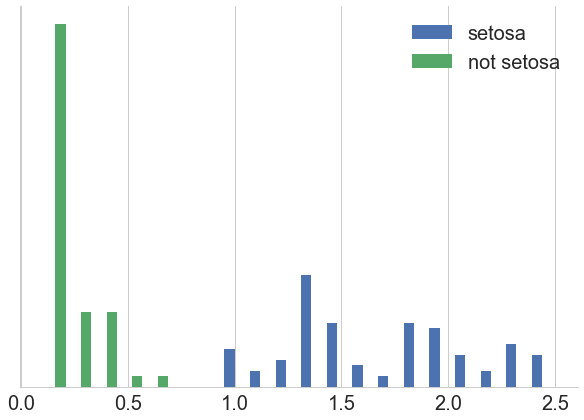

In [49]:
plot_histogram('setosa','petal_width')

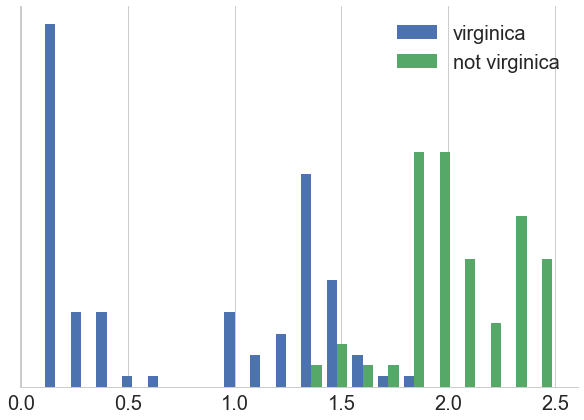

In [50]:
plot_histogram('virginica','petal_width')
# domain_petal_width = np.arange(0,3,0.01)
# predicted_proba = logistic_classifier.predict_proba(domain_petal_width.reshape(-1,1))[:,0]
# plt.plot;

# Logistic regression: guessing virginica knowing the petal width

In [105]:
x = iris['petal_width'].reshape(-1,1)
y= iris_dummies['species_virginica']

In [106]:
import sklearn.model_selection
import sklearn.linear_model

In [107]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x,y,test_size = 0.2)

In [108]:
#sns.countplot(x=x_train,hue=y_train)

In [120]:
logistic_classifier = sklearn.linear_model.LogisticRegression()

In [121]:
logistic_classifier.fit(x_train,y_train);

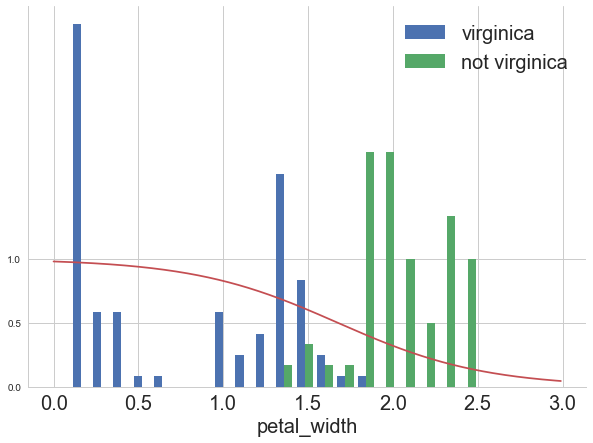

In [122]:
plot_histogram('virginica','petal_width')
domain_petal_width = np.arange(0,3,0.01)
predicted_proba = logistic_classifier.predict_proba(domain_petal_width.reshape(-1,1))[:,0]
plt.plot(domain_petal_width,predicted_proba)
plt.yticks([0,0.5,1]);

In [123]:
score_train = logistic_classifier.score(x_train,y_train)

In [124]:
prediction_train = logistic_classifier.predict_proba(x_train)
loss_train = sklearn.metrics.log_loss(y_train,prediction_train)
loss_train

0.26326109261592351

In [61]:
score_test = logistic_classifier.score(x_test,y_test)

0.8666666666666667

In [63]:
prediction_test = logistic_classifier.predict_proba(x_test)
test_loss = sklearn.metrics.log_loss(y_test,prediction_test)
print(test_loss)

0.308284121556


# Logistic regression with Keras

In [163]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.models import Model
from keras import optimizers
from keras import regularizers

In [164]:
model = Sequential()
model.add(Dense(1,input_dim=1,kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('sigmoid'))

In [165]:
sgd = optimizers.SGD(lr=0.05)

In [166]:
# model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

In [167]:
model.fit(x_train,y_train,epochs=1000, batch_size=64,verbose=2)

Epoch 1/1000
 - 0s - loss: 0.8902 - acc: 0.3000
Epoch 2/1000
 - 0s - loss: 0.8578 - acc: 0.3000
Epoch 3/1000
 - 0s - loss: 0.8279 - acc: 0.3250
Epoch 4/1000
 - 0s - loss: 0.8007 - acc: 0.3417
Epoch 5/1000
 - 0s - loss: 0.7748 - acc: 0.4417
Epoch 6/1000
 - 0s - loss: 0.7511 - acc: 0.5500
Epoch 7/1000
 - 0s - loss: 0.7293 - acc: 0.5667
Epoch 8/1000
 - 0s - loss: 0.7096 - acc: 0.5917
Epoch 9/1000
 - 0s - loss: 0.6914 - acc: 0.6000
Epoch 10/1000
 - 0s - loss: 0.6752 - acc: 0.6417
Epoch 11/1000
 - 0s - loss: 0.6606 - acc: 0.6500
Epoch 12/1000
 - 0s - loss: 0.6477 - acc: 0.6500
Epoch 13/1000
 - 0s - loss: 0.6355 - acc: 0.6583
Epoch 14/1000
 - 0s - loss: 0.6248 - acc: 0.6583
Epoch 15/1000
 - 0s - loss: 0.6148 - acc: 0.6583
Epoch 16/1000
 - 0s - loss: 0.6061 - acc: 0.6583
Epoch 17/1000
 - 0s - loss: 0.5978 - acc: 0.6583
Epoch 18/1000
 - 0s - loss: 0.5906 - acc: 0.6583
Epoch 19/1000
 - 0s - loss: 0.5837 - acc: 0.6583
Epoch 20/1000
 - 0s - loss: 0.5777 - acc: 0.7083
Epoch 21/1000
 - 0s - loss: 0

Epoch 167/1000
 - 0s - loss: 0.4021 - acc: 0.9667
Epoch 168/1000
 - 0s - loss: 0.4016 - acc: 0.9667
Epoch 169/1000
 - 0s - loss: 0.4011 - acc: 0.9667
Epoch 170/1000
 - 0s - loss: 0.4007 - acc: 0.9667
Epoch 171/1000
 - 0s - loss: 0.4002 - acc: 0.9667
Epoch 172/1000
 - 0s - loss: 0.3997 - acc: 0.9667
Epoch 173/1000
 - 0s - loss: 0.3992 - acc: 0.9667
Epoch 174/1000
 - 0s - loss: 0.3988 - acc: 0.9667
Epoch 175/1000
 - 0s - loss: 0.3982 - acc: 0.9667
Epoch 176/1000
 - 0s - loss: 0.3978 - acc: 0.9667
Epoch 177/1000
 - 0s - loss: 0.3973 - acc: 0.9667
Epoch 178/1000
 - 0s - loss: 0.3969 - acc: 0.9667
Epoch 179/1000
 - 0s - loss: 0.3964 - acc: 0.9667
Epoch 180/1000
 - 0s - loss: 0.3959 - acc: 0.9667
Epoch 181/1000
 - 0s - loss: 0.3956 - acc: 0.9667
Epoch 182/1000
 - 0s - loss: 0.3951 - acc: 0.9667
Epoch 183/1000
 - 0s - loss: 0.3946 - acc: 0.9667
Epoch 184/1000
 - 0s - loss: 0.3943 - acc: 0.9667
Epoch 185/1000
 - 0s - loss: 0.3937 - acc: 0.9667
Epoch 186/1000
 - 0s - loss: 0.3933 - acc: 0.9667


Epoch 331/1000
 - 0s - loss: 0.3522 - acc: 0.9667
Epoch 332/1000
 - 0s - loss: 0.3520 - acc: 0.9667
Epoch 333/1000
 - 0s - loss: 0.3518 - acc: 0.9667
Epoch 334/1000
 - 0s - loss: 0.3518 - acc: 0.9667
Epoch 335/1000
 - 0s - loss: 0.3515 - acc: 0.9667
Epoch 336/1000
 - 0s - loss: 0.3513 - acc: 0.9667
Epoch 337/1000
 - 0s - loss: 0.3512 - acc: 0.9667
Epoch 338/1000
 - 0s - loss: 0.3510 - acc: 0.9667
Epoch 339/1000
 - 0s - loss: 0.3508 - acc: 0.9667
Epoch 340/1000
 - 0s - loss: 0.3512 - acc: 0.9667
Epoch 341/1000
 - 0s - loss: 0.3504 - acc: 0.9667
Epoch 342/1000
 - 0s - loss: 0.3503 - acc: 0.9667
Epoch 343/1000
 - 0s - loss: 0.3504 - acc: 0.9667
Epoch 344/1000
 - 0s - loss: 0.3499 - acc: 0.9667
Epoch 345/1000
 - 0s - loss: 0.3498 - acc: 0.9667
Epoch 346/1000
 - 0s - loss: 0.3496 - acc: 0.9667
Epoch 347/1000
 - 0s - loss: 0.3494 - acc: 0.9667
Epoch 348/1000
 - 0s - loss: 0.3493 - acc: 0.9667
Epoch 349/1000
 - 0s - loss: 0.3492 - acc: 0.9667
Epoch 350/1000
 - 0s - loss: 0.3490 - acc: 0.9667


Epoch 495/1000
 - 0s - loss: 0.3318 - acc: 0.9667
Epoch 496/1000
 - 0s - loss: 0.3318 - acc: 0.9667
Epoch 497/1000
 - 0s - loss: 0.3317 - acc: 0.9667
Epoch 498/1000
 - 0s - loss: 0.3317 - acc: 0.9667
Epoch 499/1000
 - 0s - loss: 0.3316 - acc: 0.9667
Epoch 500/1000
 - 0s - loss: 0.3314 - acc: 0.9667
Epoch 501/1000
 - 0s - loss: 0.3314 - acc: 0.9667
Epoch 502/1000
 - 0s - loss: 0.3313 - acc: 0.9667
Epoch 503/1000
 - 0s - loss: 0.3313 - acc: 0.9667
Epoch 504/1000
 - 0s - loss: 0.3312 - acc: 0.9667
Epoch 505/1000
 - 0s - loss: 0.3311 - acc: 0.9667
Epoch 506/1000
 - 0s - loss: 0.3312 - acc: 0.9667
Epoch 507/1000
 - 0s - loss: 0.3309 - acc: 0.9667
Epoch 508/1000
 - 0s - loss: 0.3308 - acc: 0.9667
Epoch 509/1000
 - 0s - loss: 0.3308 - acc: 0.9667
Epoch 510/1000
 - 0s - loss: 0.3307 - acc: 0.9667
Epoch 511/1000
 - 0s - loss: 0.3306 - acc: 0.9667
Epoch 512/1000
 - 0s - loss: 0.3305 - acc: 0.9667
Epoch 513/1000
 - 0s - loss: 0.3304 - acc: 0.9667
Epoch 514/1000
 - 0s - loss: 0.3303 - acc: 0.9667


Epoch 659/1000
 - 0s - loss: 0.3219 - acc: 0.9667
Epoch 660/1000
 - 0s - loss: 0.3218 - acc: 0.9667
Epoch 661/1000
 - 0s - loss: 0.3218 - acc: 0.9667
Epoch 662/1000
 - 0s - loss: 0.3217 - acc: 0.9667
Epoch 663/1000
 - 0s - loss: 0.3217 - acc: 0.9667
Epoch 664/1000
 - 0s - loss: 0.3216 - acc: 0.9667
Epoch 665/1000
 - 0s - loss: 0.3216 - acc: 0.9667
Epoch 666/1000
 - 0s - loss: 0.3216 - acc: 0.9667
Epoch 667/1000
 - 0s - loss: 0.3216 - acc: 0.9667
Epoch 668/1000
 - 0s - loss: 0.3215 - acc: 0.9667
Epoch 669/1000
 - 0s - loss: 0.3214 - acc: 0.9667
Epoch 670/1000
 - 0s - loss: 0.3215 - acc: 0.9667
Epoch 671/1000
 - 0s - loss: 0.3213 - acc: 0.9667
Epoch 672/1000
 - 0s - loss: 0.3213 - acc: 0.9667
Epoch 673/1000
 - 0s - loss: 0.3218 - acc: 0.9667
Epoch 674/1000
 - 0s - loss: 0.3213 - acc: 0.9667
Epoch 675/1000
 - 0s - loss: 0.3212 - acc: 0.9667
Epoch 676/1000
 - 0s - loss: 0.3211 - acc: 0.9667
Epoch 677/1000
 - 0s - loss: 0.3211 - acc: 0.9667
Epoch 678/1000
 - 0s - loss: 0.3211 - acc: 0.9667


Epoch 823/1000
 - 0s - loss: 0.3166 - acc: 0.9667
Epoch 824/1000
 - 0s - loss: 0.3166 - acc: 0.9667
Epoch 825/1000
 - 0s - loss: 0.3165 - acc: 0.9667
Epoch 826/1000
 - 0s - loss: 0.3164 - acc: 0.9667
Epoch 827/1000
 - 0s - loss: 0.3164 - acc: 0.9667
Epoch 828/1000
 - 0s - loss: 0.3163 - acc: 0.9667
Epoch 829/1000
 - 0s - loss: 0.3163 - acc: 0.9667
Epoch 830/1000
 - 0s - loss: 0.3163 - acc: 0.9667
Epoch 831/1000
 - 0s - loss: 0.3162 - acc: 0.9667
Epoch 832/1000
 - 0s - loss: 0.3162 - acc: 0.9667
Epoch 833/1000
 - 0s - loss: 0.3162 - acc: 0.9667
Epoch 834/1000
 - 0s - loss: 0.3163 - acc: 0.9667
Epoch 835/1000
 - 0s - loss: 0.3161 - acc: 0.9667
Epoch 836/1000
 - 0s - loss: 0.3161 - acc: 0.9667
Epoch 837/1000
 - 0s - loss: 0.3161 - acc: 0.9667
Epoch 838/1000
 - 0s - loss: 0.3161 - acc: 0.9667
Epoch 839/1000
 - 0s - loss: 0.3161 - acc: 0.9667
Epoch 840/1000
 - 0s - loss: 0.3161 - acc: 0.9667
Epoch 841/1000
 - 0s - loss: 0.3160 - acc: 0.9667
Epoch 842/1000
 - 0s - loss: 0.3160 - acc: 0.9667


Epoch 987/1000
 - 0s - loss: 0.3133 - acc: 0.9667
Epoch 988/1000
 - 0s - loss: 0.3133 - acc: 0.9667
Epoch 989/1000
 - 0s - loss: 0.3134 - acc: 0.9667
Epoch 990/1000
 - 0s - loss: 0.3133 - acc: 0.9667
Epoch 991/1000
 - 0s - loss: 0.3133 - acc: 0.9667
Epoch 992/1000
 - 0s - loss: 0.3133 - acc: 0.9667
Epoch 993/1000
 - 0s - loss: 0.3132 - acc: 0.9667
Epoch 994/1000
 - 0s - loss: 0.3136 - acc: 0.9667
Epoch 995/1000
 - 0s - loss: 0.3133 - acc: 0.9667
Epoch 996/1000
 - 0s - loss: 0.3132 - acc: 0.9667
Epoch 997/1000
 - 0s - loss: 0.3132 - acc: 0.9667
Epoch 998/1000
 - 0s - loss: 0.3133 - acc: 0.9667
Epoch 999/1000
 - 0s - loss: 0.3132 - acc: 0.9667
Epoch 1000/1000
 - 0s - loss: 0.3131 - acc: 0.9667


# Neural Networks: when linear methods are not sufficient

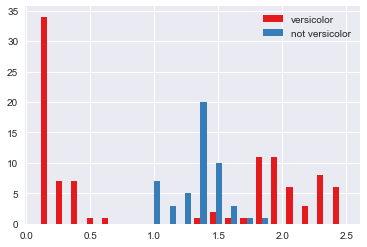

In [101]:
plot_histogram('versicolor','petal_width')

In [102]:
# for name,group in grouped:
#     print(name)
#     print(group)

In [87]:
# plt.figure(figsize=(10,7))
# sns.barplot(x='petal_length',hue='species_setosa',data=iris_dummies)

In [ ]:
colors = ['red', 'blue']
plt.hist(x, n_bins, normed=1, histtype='bar', color=colors, label=colors)